[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CCS-ZCU/pribehy-dat/blob/master/scripts/pdf.ipynb)

# PDF: Extrakce textu

**autor**: *Vojtěch Kaše* (kase@ff.zcu.cz)

[![](https://ccs.zcu.cz/wp-content/uploads/2021/10/cropped-ccs-logo_black_space_240x240.png)](https://ccs.zcu.cz)


## Úvod a cíle kapitoly

V této kapitole si ukážeme základní principy práce s PDF soubory. Formát PDF zavedl v roce 1993 John Warnock, spoluzakladatel společnosti Adobe. Cílem bylo nalézt způsob, jak by se dokumenty z jakékoli aplikace daly jednoduše ukládat, posílat v elektronickém formátu a prohlížet a tisknout na jakémkoli počítači, aniž by došlo ke změně jejich podoby. 

PDF formát je nyní standardem pro digitalizaci knih či archivních dokumentů. V tomto kontextu rozlišujeme zejména mezi PDF soubory s rozpoznanou textovou vrstvou a bez ní. Digitalizovaný dokument bez rozpoznané textové vrstvi je víceméně pouze seznam obrázků. PDF s rozpoznanou textovou vrstvou má kromě vrstvy obrázků ještě vrstvu textových prvků, tzv. textových bloků. Textový blok je entita, která sestává z dat ohledně svého geometrického postavení na stránce (typicky dva body vymezující rohy obdelníku) a sestavy znaků textu. Jedná-li se o PDF dokument, který vznikl např. převodem `.docx` souboru, lze očekávat, že textový obsah bude bezchybný. Jedná-li se však o soubor, který vznikl digitalizací analogového dokumentu, často zde narazíme na určité nedostatky spjaté s technologií OCR. Této technologii se budeme věnovat v samostatné kapitole. 

V následujícím cvičení budeme PDF soubory zpracovávat pomocí Python knihovny `PyMuPDF`, která se do Python prostředí importuje pod přezdívkou `fitz`. 

Toto cvičení je postaveno na textech zpřístupněných na stránkách [scriptum.cz](https://scriptum.cz). Tato webová platforma zpřístupňuje českou exilovou a samizdatovou literaturu z období komunismu. Jedná se o projekt Sdružení občanů Exodus v Plzni a Třemošné, který funguje od roku 2007. Digitalizace textů je náplní práce lidí se zdravotním handicapem v rámci chráněné dílny. Jedná se o unikátní kolekci několika set titulů a více než 11 tisíc souborů. 

## Cvičení

In [3]:
%%capture
!pip install PyMuPDF stanza wordcloud
import fitz
import stanza
stanza.download("cs")
nlp = stanza.Pipeline("cs")
from wordcloud import WordCloud
import requests
import io
import pickle
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re
from bs4 import BeautifulSoup
import pandas as pd
import nltk


Pro ukázku si nyní do našeho Python prostředí načteme jedno číslo exilového časopisu *Studie*, revue Křesťanské akademie.  

In [4]:
url = "https://files.scriptum.cz/scriptum/studie/studie_1958_002_ocr.pdf"
pdf_object = io.BytesIO(requests.get(url).content)

In [5]:
doc = fitz.open("pdf", pdf_object.read())

In [6]:
doc.page_count

68

In [7]:
p = doc.load_page(10)

In [8]:
p

page 10 of <memory, doc# 1>

In [9]:
pix = p.get_pixmap()

In [10]:
pix.width

595

In [11]:
pix.height

842

Příslušný obrázek stránky má v tuto chvíli podobu matice či tabulky o 585 sloupcích a 769 řádcích. Co se však nachází v jednotlivých buňkách? Abychom to mohli blíže prozkoumat, data si ještě jednou prozatimně převedeme do standardního maticového objektu (tzv. `array`) knihovny `numpy`. A následně se podíváme na malý výřez dat pro několik pixelů:

In [12]:
np_array = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)
np_array[400:404, 200:205]

array([[[253, 253, 253],
        [196, 196, 196],
        [ 99,  99,  99],
        [228, 228, 228],
        [255, 255, 255]],

       [[110, 110, 110],
        [101, 101, 101],
        [ 93,  93,  93],
        [241, 241, 241],
        [255, 255, 255]],

       [[ 39,  39,  39],
        [108, 108, 108],
        [ 51,  51,  51],
        [208, 208, 208],
        [255, 255, 255]],

       [[220, 220, 220],
        [224, 224, 224],
        [ 68,  68,  68],
        [199, 199, 199],
        [255, 255, 255]]], dtype=uint8)

Takto vypadají data pro celkově 20 pixelů. Jedná se o pixely z řádek 400 až 403 a sloupců 200 až 204 (pozor na indexování od nuly).

Trojice číslic udává pro každý pixel jeho barvu ve standardu RGB, o kterým si můžeme přečíst více např. na wikipedii [zde](https://cs.wikipedia.org/wiki/RGB). Každé číslo může nabývat na hodnotě 0-255 a jednotlivé hodnoty odpovídají intenzitám červené (*R*), zelené (*G*) a modré (*B*). Černá barva je definována hodnotami (0, 0, 0), zatímco bílá hodnotami (255, 255, 255). V případě že se jedná o obrázek, který pochází z textového dokumentu na bílém pozadí, můžeme očekvávat, že velké množství pixelů bude nabývat hodnot (255,255,255). Tam, kde se naopak nacházejí nulové hodnoty, bude se jednat o černou. Tam, kde jsou hodnoty pro všechny tři barvy stejné, půjde o barvu na škále šedi, od úplné černé až po bílou. 

To jsou důležité vlastnosti, na kterých je postaveno velké množství algoritmů pro zpracování obrázků, které mají například za cíl zvýšit jejich kontrast apod. To je klíčové i pro potřeby rozpoznávání znaků (OCR), kterému se budeme věnovat níže.

Nyní se však již podíváme na obrázek stránky jako takový. Můžeme jej vygenerovat přímo z maticových dat pomocí knihovny `matplotlib`:

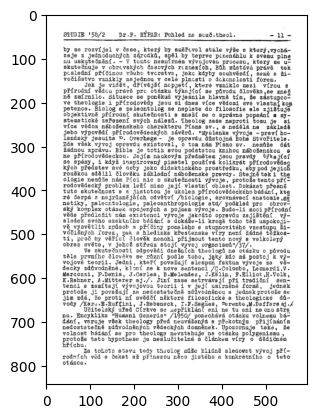

In [13]:
plt.imshow(np_array)

Snadno si zobrazíme např. pouze výřez této stránky.

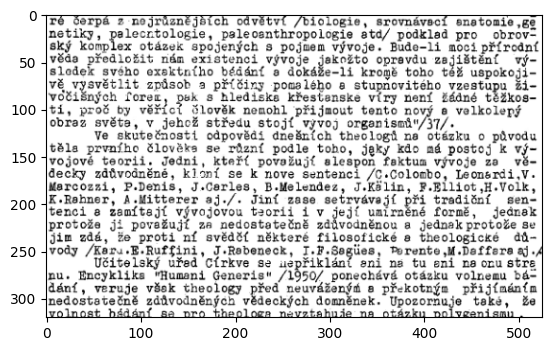

In [14]:
plt.imshow(np_array[410:730, 35:560])

Nyní se vraťme k našemu objektu `p`, který reprezentuje veškerá data spojená s danou stránkou. Velice přímočarým způsobem získáme kompletní textový obsah:

In [15]:
print(p.get_text())

STUDIE '56/2 
Dr.E. RYPAR: Pohled ne scuč.theol. 
- 11 -
by se rozvíjel v čase, který by směřoval stále výše a který,vychá-
zeje z jednoduchých zárodků, spěl by teprve pcnenáhlu k svému plne 
mu uskutečnění. - V tomto nesmírném vývodovém procesu, který se u-
skutečnuje v obrovských Časových rozmezích, Bůh zůstává právě 
tak 
poslední příčinou, všeho tvorstva, jako kdyby souhvězdí, země a Ži-
vočišstvo vznikly najednou v celé plnosti a dokonalosti forem« 
Jak je vidět, dřívější n&pjetí, které vzniklo mezi 
vírou e 
přírodní vědou právě pro otázku týkající se původu člověka,se znač 
ně zmírnilo. Situace se poněkud vyjasnila hlavně tím, že zástupco-
vé theclogie i přírodovědy jsou si dnes více vědomi své vlastn£ kom 
petence. Biolog a paleontolog se neplete do filosofie ale zjištujě 
objektivně přírodní skutečnosti a snaží se o správné popsání a sy-
stematické zařazení svých nálezů. íheolog zase naproti tomu je 
si 
více vědom náboženského charakteru Písma sv., a nedělá na 
základě 
jeho 

In [16]:
# Tato buňka slouží ke kontrole průchodu tímto cvičením. 
# Pokud toto cvičení plníte v rámci svých studijních povinností na ZČU, buňku spusťte a držte se instrukcí.
exec(requests.get("https://sciencedata.dk/shared/856b0a7402aa7c7258186a8bdb329bd3?download").text)
kontrola_pruchodu(ntb="pdf", arg1=p.get_text())

Pokročilejší způsob představuje vyjmout textová data ze stránky po jednotlivých textových blocích, které obsahují i informaci o svém geometrickém umístění uvnitř stránky:

In [17]:
p = doc.load_page(8)
textblocks = p.get_text_blocks() # ("blocks")
textblocks[:15]

[(0.0,
  0.0,
  595.2000122070312,
  841.9199829101562,
  '<image: DeviceRGB, width: 1240, height: 1754, bpc: 8>',
  0,
  1),
 (33.599998474121094,
  38.437477111816406,
  572.9759521484375,
  56.3124885559082,
  "STUDIE \n'58/2 \nDr.Fr. FÍ PAR: Pohled na součes.theol. \n- 9 -\n",
  1,
  0),
 (33.360015869140625,
  69.63748931884766,
  571.75537109375,
  140.07249450683594,
  'jsou dvě pole, jež nemohou zasahovBt jedno do druhého. Jejich poj-\nmová struktura je tak různá, že není dovoleno přenášet různě prvky \ns jednoho do druhého oboru"/29/ Z toho důvodu moderní fysika \npřes \nvšechny sve pokroky nemůže přinést nic nového k obohacení e prohlou \nbení theologické nauky o Eucharistii. \n',
  2,
  0),
 (31.680038452148438,
  143.07748413085938,
  574.5572509765625,
  798.392822265625,
  'B á d á n í \nna \np o l i \nb i o l o g i c k é m \npřináší v po3ledních \nlétech stále více důkazů pro podstatnou rozdílnost mezi říší nerost \nnou, oživenou přírodou a člověkem / 3 0 / . Tím, Že se 

Geometrie zde vymezuje dva body ohraničující obdelník, v němž se text nachází:

In [18]:
rect = textblocks[2][:4]

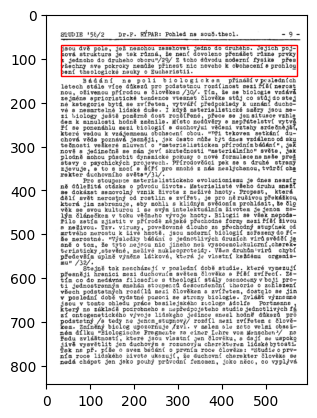

In [19]:
fig, ax = plt.subplots()
pix = p.get_pixmap()
np_array = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)

ax.imshow(np_array)
patch = patches.Rectangle((rect[0], rect[1]),  # Bottom left corner
                          rect[2] - rect[0],  # Width
                          rect[3] - rect[1],  # Height
                          linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(patch)

Mít povědomí o těchto strukturálních vlastnostech PDF dokumentů je velice důležité, když z těchto dokumentů chceme získat strojově čitelný text pro další textové analýzy. PDF dokumenty jsou například často opatřeny záhlavím či zápatím, kde se objevuje třeba název periodika (jako je tomu zde), jméno autora, jméno příspěvku či číslo stránky. Vyextrahujeme-li ze všech stránek v daném dokumentu syrový text pomocí p.get_text(), budeme v našem textu mít i řetězce znaků z těchto textových bloků, což není žádoucí. Buď se tomu pokusíme předejít již při samotné extrakci, kdy můžeme využít geometrické polohy jednotlivých text bloků,  nebo se těchto dat pokusíme zbavit během následného čištění, např. pomocí *regulérních výrazů* (viz příslušná kapitola). Který případ je vhodnější závisí případ od případu a vyžaduje testování. Zde se budeme držet druhého případu.

In [20]:
text = ""
for p in doc:
    text += p.get_text()

In [21]:
text[5000:6000]

'ecky školených odborníků, jejichž práce znamenají cenný \npřinos k řešení styčných otázek mezi vírou a vedou. \nTak na př, Heimo Dolch, theolog i fysik zároveň /žák Heisen-\nbergův/ ukazuje v knížce "Theologie und Physik»/5/, jak moderní fy-\nsiky usnadnuje dnešnímu ČlQvěku uznat \nm o ž n o s t \nz á z r a k u . V té-\nto studii autor vychází z úvahy c růzhosti zákonů v oblasti makro-\nf^sikální a mikrofysikální, Jak známo, klasické fysikální zákony ma \nji platnost jen omezenců: platí jen ve sféře makrofysikální, zatím-\nco v nitru atomu moderní jaderná fysika objevila zákony jine. z to-\nho vsak plyne tento důsledek: Kdyby fysik znal na př. jenom oblast \nmikrofysikální a nic více, jistě by se musil domnívat, že mikrofysi \nkální zákony jsou všude stejně platné a že nepřipouštějí žádných vj \njimek» Zkušenost mu však říká něco jiného; poučuje ho, že tyto záko \nnyjisou omezené jen na nitro atomu a že kromě mikrokosmu existuje ~ \nještě jiná sféra /\'makrofysikální/, která má své vl

Zkusme se zbavit všech záhlaví pomocí regexu:

In [22]:
pattern = "(_+)?(\n?Studie[\s_]+\d{4}\n?)(\W*\w{0,3}\s*/\s*\d\n?)?"
re.findall(pattern, text)[:10]

[]

In [23]:
text = re.sub(pattern, "\n", text)
text[3000:5000]

'vějšího překračování své vlastní kompetence, t . j . všech neoprávně- " \nných zásahů do oboru filosofie a theologie a uvolnily tak metafysi-\nce cestu k důkazům Boží existence a božského původu světa ./1/ \nTheolog bere samozřejmě s radostí a s vnitřním zadostiučině-\nním na vědomí tuto skutečnost, neztrácí však přitom se zřetele urči \nté zásady! \n- Nehledá předně a nebude nikdy hledat v přírodních vědách dů \nkazy pro theologické otázky. Jemu stačí, odstraní-li fysika, chemie \nnebo biologie překážky, které se nakupily protiprávně v minulém sto \nletí na cestě vedoucí k náboženství, \n- Chce se chránit vě&ker.ého filosoficky ne věcného výkladu jed \nnotlivých výsledků přírodních věd. Bude v tom ohledu velmi opatrný" \njednak z toho důvodu, že přírodní vědy jsou v neustálém vývoji a jed \nnak proti, ze jejich výsledky nás staví často před skutečnosti, pro \nktere nemáme přiléhavých pojmů. \n- Nebude se pouštět do těchto otázek bez důkladné znalosti \npříslušného useku přírodních vě

Na text aplikujeme ještě několik čistících funkcí.

In [24]:
text = re.sub("\xad\n", "", text)
text = text.replace("- \n", "")
text = re.sub("\s\s+", " ", text.replace("\n", " "))
text[10000:11000]

'y totožní činitelé vyvolávají různé účinky. /10-/ Toto měl patrně na mysli též sv. Otec Pius X I I . ve své promlu vě o moderní fysice / r . 1 9 5 5 / , ve které zaujal stanovisko ke shora ü vedenemu problérau. Prohlásil, že není možno mluvit o nějaké svobodě v mikrokosrnu. Poukázal sice ns to, že elementární Částice během vel mi krátkého intervalu odpovídají různým způsobem na tytéž vnější vlivy, a následkem toho se jejich chování nedá přesně určit. "Avšak síly hmotné přírody - praví - řídí se svými vlasními vnitřními zá- kony, které vylučují každou svcbodu a tím i každou pravděpodobnost." /11/ Určitá skupina přírodovědecky orientovaných a přitom nábožen- sky založených filosofů uvítala naopak s velkou sympatií domněnku o mikrofysikálním indeterminismu a snažila se jí využit k podepření a "přírodovědeckému zdůvodnění" svobody lidské vůle./12/ Je to však námaha zřejmě zbytečná, protože otázka svobody lidské vůle je na a- tomickém determinismu nebe indeterminisrnu úplně nezávislá. Lids

Výsledek zdaleka není perfektní. V textu stále vidíme řadu problémů. Některé souvisejí s formátováním, jiné jsou dědictvím OCR analýzy. Pro naše aktuální potřeby však text v této podobě postačuje. 

Zkusme se však podívat na jiný text z téhož periodika:

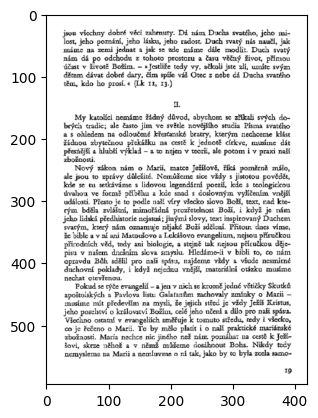

In [25]:
url = "https://files.scriptum.cz/scriptum/studie/studie_1978_055_ocr.pdf"
pdf_object = io.BytesIO(requests.get(url).content)
doc = fitz.open("pdf", pdf_object.read())
p = doc.load_page(20) # vybereme stránku
pix = p.get_pixmap()
np_array = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)


plt.imshow(np_array)

Vidíme, že text je nyní formátovaný odlišně. Například chybí původní záhlaví. Namísto toho vidíme v zápatí čísla stránek. V extrahovaném textu se pokusíme nyní zbavit i těch.

In [26]:
p.get_text()

'jsou všechny dobré věci zahrnuty. Dá nám Ducha svatého, jeho mi-\nlost, jeho poznání, jeho lásku, jeho radost. Duch svatý nás naučí, jak \nmáme na zemi jednat a jak se zde máme dále modlit. Duch svatý \nnám dá po odchodu z tohoto prostoru a času věcný život, přímou \núčast v životě Božím. - »Jestliže tedy vy, ačkoli jste zlí, umíte svým \ndětem dávat dobré dary, čím spíše váš Otec z nebe dá Ducha svatého \ntěm, kdo ho prosí. « (Lk n , 13.) \nII. \nMy katolíci nemáme žádný důvod, abychom se zříkali svých do-\nbrých tradic; ale často jim ve světle novějšího studia Písma svatého \na s ohledem na odloučené křesťanské bratry, kterým nechceme klást \nžádnou zbytečnou překážku na cestě k jednotě církve, musíme dát \npřesnější a hlubší výklad - a to nejen v teorii, ale potom i v praxi naší \nzbožnosti. \nNový zákon, nám o Marii, matce Ježíšově., říká poměrně málo, \nale jsou to zprávy důležité. Nemůžeme sice vždy s jistotou povědět, \nkde se tu setkáváme s lidovou legendární poezií, kde s teo

In [27]:
re.sub("\n\s?\d{1,3}\s?\n", "\n", p.get_text())

'jsou všechny dobré věci zahrnuty. Dá nám Ducha svatého, jeho mi-\nlost, jeho poznání, jeho lásku, jeho radost. Duch svatý nás naučí, jak \nmáme na zemi jednat a jak se zde máme dále modlit. Duch svatý \nnám dá po odchodu z tohoto prostoru a času věcný život, přímou \núčast v životě Božím. - »Jestliže tedy vy, ačkoli jste zlí, umíte svým \ndětem dávat dobré dary, čím spíše váš Otec z nebe dá Ducha svatého \ntěm, kdo ho prosí. « (Lk n , 13.) \nII. \nMy katolíci nemáme žádný důvod, abychom se zříkali svých do-\nbrých tradic; ale často jim ve světle novějšího studia Písma svatého \na s ohledem na odloučené křesťanské bratry, kterým nechceme klást \nžádnou zbytečnou překážku na cestě k jednotě církve, musíme dát \npřesnější a hlubší výklad - a to nejen v teorii, ale potom i v praxi naší \nzbožnosti. \nNový zákon, nám o Marii, matce Ježíšově., říká poměrně málo, \nale jsou to zprávy důležité. Nemůžeme sice vždy s jistotou povědět, \nkde se tu setkáváme s lidovou legendární poezií, kde s teo

In [28]:
text = ""
for p in doc:
    text += p.get_text()

In [29]:
pattern = "(_+)?(\n?Studie[\s_]+\d{4}\n?)(\W*\w{0,3}\s*/\s*\d\n?)?"
text = re.sub(pattern, "\n", text)
text = re.sub("\n\s?\d{1,3}\s?\n", "\n", text)
text = re.sub("\xad\n", "", text)
text = text.replace("- \n", "")
text = re.sub("\s\s+", " ", text.replace("\n", " "))
text[10000:12000]

' mezi oběma funkcemi Ducha svatého. Jaký je pomer mezi Duchem přebývajícím a Duchem přichá- zejícím? - čili, jak se k sobě mají charismata a ovoce Ducha, tj. mravní a duchovní výsledky křesťanského úsilí o bohulibý život? Je to vlastně otázka po vnitřním napětí v samé bytosti Ducha svatého, jež jsme si zpříkladnili rozlišováním jeho dvou funkcí, neboť jej známe jen z jeho působení. Na tuto otázku odpovídají ze zkušenosti tí z křesťanů, kteří funkci charismat již dlouho znají, členové letničních linutí. Ti vědí, že charisniatik, který zároveň nejde cestou křesťanského mravního i duchovního snažení, vedoucí k posvěcení (dle pietistického schématu) žíi k duchovní iluminaci (dle mystiků) - není genuirmím křesťanem podle evangelia. O tom svědci H. K. Neerskov, člen letničního sboru v Kodani: » Duck sv. v nich (ckarismaticích) sice přebývá, ale oni jej, žel, ignoruji Nevědí, jaké požehnání .přináší život v Duchu svatém, a proto nad nimi Duch nemá moci. Jsou více zaujati silou Ducha ... užív

Výsledný text má daleko od dokonalosti. My se s ním však nyní spokojíme a postoupíme dále. 



### Aplikace NLP na získaný text

In [30]:
chunks = re.findall(r'.{0,50000}\.\s', text, re.DOTALL)
chunks_end = sum([len(chunk) for chunk in chunks])
chunks.append(text[chunks_end:])
docs = [nlp(chunk) for chunk in chunks]

In [31]:
[len(chunk) for chunk in chunks]

[49939, 49934, 49952, 49928, 3847, 6]

In [32]:
lemmatized_sents = []
for doc in docs:
    for sent in doc.sentences:
        lemmatized_sents.append([t.lemma for t in sent.words if t.upos in ["PROPN", "NOUN", "VERB", "ADJ"]])

In [33]:
lemmatized_sents[1000:1010]

[['diskontinuita',
  'vidět',
  'přijímat',
  'zastávat',
  'moci',
  'vidět',
  'kontinuita',
  'muset',
  'vědět',
  'ostrovtip',
  'vymýšlet',
  'bystrozraký',
  'odhalovat',
  'duše',
  'konstatovat',
  'kontinuita',
  'Ježíš'],
 ['n',
  'člověctví',
  'zneklidňovaný',
  'Cyril',
  'Václav',
  'Hus',
  'Bridel',
  'Palacký',
  'Ma',
  'saryk',
  'marxista',
  'Machovec',
  'Gardavský',
  'mnohý',
  'jiný'],
 ['kontinuum', 'mít', 'institucionální', 'vyjádření', 'pražský', 'biskupství'],
 ['možný',
  'pozorný',
  'filosof',
  'kultura',
  'přehlédnout',
  'tisíciletý',
  'trvání',
  'instituce'],
 ['možný', 'fakt', 'trvání', 'skrývat', 'pozoruhodný'],
 ['přípustný', 'dovolit', 'přehlédnutí'],
 ['jasný', 'kontinuum', 'Ježíš', 'působit', 'hrozný', 'diskontinum'],
 ['kvas',
  'svoboda',
  'pozvedat',
  'člo',
  'věka',
  'kosmický',
  'zákonitost',
  'historický',
  'fatalismus',
  'psychý',
  'logický',
  'determinismus',
  'přehodnocovat',
  'hodnota',
  'viz',
  'Blahosla',
  'venstv

In [ ]:
kontrola_pruchodu(ntb="pdf", arg1=lemmatized_sents[50])

> **Zde končí povinná část cvičení.** 

## Rozšiřující analýza 1: Extrakce textu ze všech čísel periodika

Nyní postoupíme dále a aplikujeme tento přístup na vyextrahování textu ze všech čísel daného periodika: https://scriptum.cz/cs/periodika/studie.

Použijeme obdobný postup, jaký jsme použili v kapitole o webscrapingu. Nejprve si vyextrahujeme seznam jmen všech relevantních souborů (zajímají nás pouze souboru, které končí "ocr.pdf" - i zde se nám hodí regex).

Tyto funkce jsou však již výpočetně poměrně náročné, tudíž tuto sekci je možné přeskočit.

In [34]:
resp = requests.get("https://scriptum.cz/cs/periodika/studie")
soup = BeautifulSoup(resp.content)
hrefs = [a.get('href') for a in soup.find_all("a")]
hrefs = [href for href in hrefs if re.search("ocr\.pdf$", href)]
hrefs = [href for href in hrefs if not ("rejstrik" in href or "obsah" in href)]
hrefs[:20]

['https://files.scriptum.cz/scriptum/studie/studie_1958_002_ocr.pdf',
 'https://files.scriptum.cz/scriptum/studie/studie_1958_003_ocr.pdf',
 'https://files.scriptum.cz/scriptum/studie/studie_1959_004_ocr.pdf',
 'https://files.scriptum.cz/scriptum/studie/studie_1960_006_ocr.pdf',
 'https://files.scriptum.cz/scriptum/studie/studie_1961_007_ocr.pdf',
 'https://files.scriptum.cz/scriptum/studie/studie_1961_005_ocr.pdf',
 'https://files.scriptum.cz/scriptum/studie/studie_1962_008_ocr.pdf',
 'https://files.scriptum.cz/scriptum/studie/studie_1963_009_ocr.pdf',
 'https://files.scriptum.cz/scriptum/studie/studie_1965_010_ocr.pdf',
 'https://files.scriptum.cz/scriptum/studie/studie_1965_011_ocr.pdf',
 'https://files.scriptum.cz/scriptum/studie/studie_1966_012_ocr.pdf',
 'https://files.scriptum.cz/scriptum/studie/studie_1967_013_ocr.pdf',
 'https://files.scriptum.cz/scriptum/studie/studie_1968_014_ocr.pdf',
 'https://files.scriptum.cz/scriptum/studie/studie_1968_015_ocr.pdf',
 'https://files.scri

In [35]:
len(hrefs)

104

Nyní si vytvoříme funkci, do které vnoříme všechny extrakční, transformační a čistící procedury, které jsme prošli výše.  

In [36]:
def get_cleaned_text(url):
    try:
        filename = url.rpartition("/")[2]
        pdf_object = io.BytesIO(requests.get(url).content)
        doc = fitz.open("pdf", pdf_object.read())
        text = ""
        for p in doc:
            text += p.get_text()
        pattern = "(_+)?(\n?Studie[\s_]+\d{4}\n?)(\W*\w{0,3}\s*/\s*\d\n?)?"
        text = re.sub(pattern, "\n", text)
        text = re.sub("\n\s?\d{1,3}\s?\n", "\n", text)
        text = re.sub("\xad\n", "", text)
        text = re.sub("\s\s+", " ", text.replace("\n", " "))
        text = text.replace("- \n", "")
        year = int(re.search("\d{4}", filename).group())
        return filename, year, text
    except:
        pass

A následně tuto funkci aplikujeme jeden po druhém na všechny dostupné soubory pomocí cyklu FOR. Máme před sebou více než 100 jmen souborů, tj. vzneseme více než 100 HTTP dotazů. Tudíž provedení kódu zabere nějaký čas.

In [37]:
%%time
scriptum_data = []
for filename in hrefs:
    filename, year, text = get_cleaned_text(filename)
    scriptum_data.append({"filename" : filename, "year" : year, "text" : text})

CPU times: user 28.2 s, sys: 8.48 s, total: 36.7 s
Wall time: 1min 29s


Vyextrahovaná data si převedeme do objektu typu `pandas.DataFrame` 

In [38]:
scriptum_df = pd.DataFrame(scriptum_data)
scriptum_df.head(10)

,filename,year,text
0,studie_1958_002_ocr.pdf,1958,"""Pravda vás osvobodí (Jn 8, 32) KŘESŤANSKÁ AKA..."
1,studie_1958_003_ocr.pdf,1958,""" Pravda vás osvobodí"" <JN 8, 32) KŘESŤANSKÁ A..."
2,studie_1959_004_ocr.pdf,1959,""" Pravda vás osvobodí "" (Jn a, 32) v ,L K Ř E ..."
3,studie_1960_006_ocr.pdf,1960,"WWi: WĚĚKBKm ""Pravda vás osvobodí (Jn 8,32) K ..."
4,studie_1961_007_ocr.pdf,1961,"""Pravda vás osvobodí (Jn 8,32) K Ř E S Ť A N S..."
5,studie_1961_005_ocr.pdf,1961,"""Pravda vás osvobodí (In IS.K) K Ř E S Ť A N S..."
6,studie_1962_008_ocr.pdf,1962,"""l'ravda vas osvobodí ÍJ-i H.32) K Ř E S Ť A N..."
7,studie_1963_009_ocr.pdf,1963,""" Pravda vás osvobodí "" (Jn 8,32) KŘESŤANSKÁ A..."
8,studie_1965_010_ocr.pdf,1965,"41 Pravda vás osvobodí "" <Jn 8,32) KŘESŤANSKÁ ..."
9,studie_1965_011_ocr.pdf,1965,""" Pravda vás osvobodí "" (Jn 8.32) K Ř E S Ť A ..."


Spočteme počet znaků v každém z námi vyextrahovaných textů a vytvoříme nový sloupec "n_chars", kam tuto hodnotu uložíme.

In [39]:
scriptum_df["n_chars"] = scriptum_df["text"].str.len()
scriptum_df.head(5)

,filename,year,text,n_chars
0,studie_1958_002_ocr.pdf,1958,"""Pravda vás osvobodí (Jn 8, 32) KŘESŤANSKÁ AKA...",199361
1,studie_1958_003_ocr.pdf,1958,""" Pravda vás osvobodí"" <JN 8, 32) KŘESŤANSKÁ A...",200051
2,studie_1959_004_ocr.pdf,1959,""" Pravda vás osvobodí "" (Jn a, 32) v ,L K Ř E ...",165962
3,studie_1960_006_ocr.pdf,1960,"WWi: WĚĚKBKm ""Pravda vás osvobodí (Jn 8,32) K ...",172584
4,studie_1961_007_ocr.pdf,1961,"""Pravda vás osvobodí (Jn 8,32) K Ř E S Ť A N S...",125453


Díky tomu můžeme sečíst celkový počet znaků všech textů z daného periodika.

In [40]:
scriptum_df["n_chars"].sum()

32308880

Tímto se nám tedy dostal do rukou další nemalý dataset zajímavých kulturních dat. Pokud pracujeme s repozitoří "pribehy-dat" jako celkem, dataset si uložíme do podsložky data:  

In [ ]:
#scriptum_df.to_json("scriptum_df.json")

## Rozšiřující analýza 2: Zpracování textových dat

Nyní trochu přeskočíme k tématu, kterým se budeme zabývat samostatně v jedné z jiných kapitol: kvantitativní textová analýza. Následující sérii kroků proto si proto v tuto chvíli nebudeme podrobně vysvětlovat, zaměříme se až na výsledná data.

Budeme k nim potřebovat knihovnu stanza a model pro předzpracování textových dat v češtině.

In [41]:
#scriptum_df = pd.read_json("scriptum_df.json")

Pro testovací účely si vybereme jeden text z jednoho čísla:

In [42]:
text = scriptum_df["text"].tolist()[0]
text[2000:3000]

"es jasné, že o nějakých rozporech mezi pravdami zjevení Božího a mezi pravou vědou nemůže být řeči. Tyto potíže existují jen u lidí, kteří zůstávají na povrchu a nejdou k jád^u věci. Ve skutečnosti však, máme-li na zřeteli nábožensko-mrajr ní učel Písma sv., a hlavně chápeme-li jeho výpovědi v rámci lite- rárního druhu příslušné knihy a odlišujeme-li přesně náboženskou pravdu, kterou chtěl Bůh zjevit, od starověkého Šatu, kterým ji při STUDIE '58/2 Dr.Fr. FÍ PAR: Pohled na součes.theol. -4- oděl svatopisec, shledáme, že mezi vírou 8 moderním světovým názorem panuje soulad, který přímo udivuje» Když po druhé světové válce začala vycházet velmi četná díla o nových objevech na poli nejrůznějších odvětví přírodních věd, bylo jednou z nejradostnějších konstatscí to, že nové objevy nestojí v žád ném rozporu s náboženstvím. Právě naopak: přírodní vědy samy se ob-~ rátily proti dosavadnímu mechanistickému materialismu, vzdaly se dři vějšího překračování své vlastní kompetence, t . j . všech n

Na celý dokument aplikujeme jazykový model pro předzpracování, který text automaticky:
* rozdělí do vět
* věty do slov
* jednotlivým slovům přiřadí *lemmata*, tj. převede je do tvarů, jak je najdeme ve slovníku (např. "je" -> "být").
* přiřadí jim "part-of-speech" (POS) tagy (např. "NOUN", "VERB" apod. "PUNCT" apod.)

In [43]:
len(text)

199361

In [44]:
%%time
doc = nlp(text)

CPU times: user 35.9 s, sys: 8.36 s, total: 44.2 s
Wall time: 31.1 s


Vytvořili jsme nový `stanza` objekt `doc`, který obsahuje podrobně jazykově anotovanou reprezentaci celého textu. Z této reprezentace si nyní vyjmeme pouze lemmata vybraných slovních druhů: 

In [45]:
lemmatized_sents = []
for sent in doc.sentences:
    lemmatized_sents.append([t.lemma for t in sent.words if t.upos in ["PROPN", "NOUN", "VERB", "ADJ"]])
print(lemmatized_sents[100:110])

[['přepodstata', 'názor', 'molekula', 'atom', 'chléb', 'víno', 'prát', 'tělo', 'Kristův', 'zůstat', 'zásah', 'boží', 'uchovaný', 'akcident', 'pozorovatelný', 'našimý', 'smysl', 'pře', 'stroj'], ['zmíněný', 'autor', 'aplikace', 'substance', 'akcident', 'fysický', 'skutečnost', 'nutný', 'způsob', 'možný', 'uchránit', 'pojem', 'přepodstatnení', 'pouhý', 'závazný', 'konceptualispj'], ['řešení', 'prof', 'C', 'Colombo', 'R', 'Masi', 'namítat'], ['podstata', 'chléb', 'víno', 'pochyba', 'nost', 'hmotný', 'skutečnost', 'dát', 'ztotožňovat', 'fysický', 'skutečnost', 'znánre', 'moci', 'objevený', 'cnost'], ['pojem', 'psát', 'prof', 'Masi', 'vztahující', 'Euch', 'ristiie', 'podstata', 'změna', 'způsob', 'akcident', 'mít', 'význam', 'filosofický', 'patřit', 'metafysice', 'hmota'], ['moderní', 'fysika', 'roz', 'díl', 'fysika', 'aristc', 'telský', 'pohybovat', 'pole', 'metafysickérn', 'studovat', 'hmotný', 'věc', 'vnější', 'fenOmanický', 'stránka'], ['Zají', 'mít', 'přístupný', 'smysl', 'měřicí', 'me

Ani v tomto případě nejsou výsledky ani zdaleka perfektní. Vše se odvíjí zejména z kvality vstupních dat. Vidíme např., že model si nedokáže poradit se slovy, které jsou ve stupních datech zachycena v rozdělené podobě apod. I přesto nyní postoupíme dále a aplikujeme danou proceduru na texty všech čísel. 

Opět si pro tento účel nadefinujeme speciální funkci.

In [ ]:
processed = []
!mkdir data
!mkdir data/large_files
!mkdir data/large_files/lemsents
def get_lemmatized_sentences(filename, text, n_chars):
    if filename not in ["studie_1990_132_ocr.pdf"]:
        if filename + ".pickle" not in os.listdir("../data/large_files/lemsents/"):
            chunks = re.findall(r'.{0,50000}\.\s', text, re.DOTALL)
            chunks_end = sum([len(chunk) for chunk in chunks])
            chunks.append(text[chunks_end:])
            docs = [nlp(chunk) for chunk in chunks]
            lemmatized_sents = []
            for doc in docs:
                for sent in doc.sentences:
                    lemmatized_sents.append([t.lemma for t in sent.words if t.upos in ["PROPN", "NOUN", "VERB", "ADJ"]])
            processed.append(filename)
            pathfn = "data/large_files/lemsents/" + filename + ".pickle"
            with open(pathfn, 'wb') as f:
                pickle.dump(lemmatized_sents, f)
            print(filename, n_chars, len(processed))
        else:
            pathfn = "data/large_files/lemsents/" + filename + ".pickle"
            with open(pathfn, 'rb') as f:
                lemmatized_sents = pickle.load(f)
    else:
        lemmatized_sents = None
    return lemmatized_sents

Aplikace této funkce na všechny dokumenty v seznamu však zabere značný čas. Abychom se vyhnuli čekání, načteme si proto data, v kterých jsem již tuto proceduru aplikoval dříve (jak jsem to provedl je vidět v zakomentovaných příkazech v buňce níže.

In [46]:
%%time
#scriptum_df["lemmatized_sents"] = scriptum_df.apply(lambda row: get_lemmatized_sentences(row["filename"], row["text"], row["n_chars"]), axis=1)
# scriptum_df.to_json("../data/scriptum_df_lemmata.json")
scriptum_df = pd.read_json("../data/scriptum_df_lemmata.json")
scriptum_df.head(5)

CPU times: user 619 ms, sys: 147 ms, total: 766 ms
Wall time: 881 ms


,filename,year,text,n_chars,lemmatized_sents
0,studie_1958_001_ocr.pdf,1958,"""Pravda vás osvobodí"" (Jn 8, 32) KŘESŤANSKÁ AK...",215339,"[[pravda, osvobodit, Jn, křesšanský, akademie,..."
1,studie_1958_002_ocr.pdf,1958,"""Pravda vás osvobodí (Jn 8, 32) KŘESŤANSKÁ AKA...",199361,"[[pravda, osvobodit, Jn, křesšanský, akademie,..."
2,studie_1958_003_ocr.pdf,1958,""" Pravda vás osvobodí"" <JN 8, 32) KŘESŤANSKÁ A...",200051,"[[pravda, osvobodit, <, JN, křesšanský, akadem..."
3,studie_1959_004_ocr.pdf,1959,""" Pravda vás osvobodí "" (Jn a, 32) v ,L K Ř E ...",165962,"[[pravda, osvobodit, Jn, v, L, K, Ř, E, S, Ť, ..."
4,studie_1960_006_ocr.pdf,1960,"WWi: WĚĚKBKm ""Pravda vás osvobodí (Jn 8,32) K ...",172584,"[[WWi, Wěěkbě, pravda, osvobodit, Jn, K, Ř, E,..."


### Nejčastější slova po obdobích

In [47]:
periods_freqs = {}
periods = [(1958,1968), (1969,1976), (1977,1990)]
periods_labels = ["Studie {0}-{1}".format(str(period[0]), str(period[1])) for period in periods]
for period, period_label in zip(periods, periods_labels):
    subset_df = scriptum_df[scriptum_df["year"].between(period[0], period[1])]
    lemmatized_sents = [sentences for sentences in subset_df["lemmatized_sents"] if sentences != None]
    sentences_flat = [sent for file_sents in lemmatized_sents for sent in file_sents]
    lemmata_list = [lemma for sent in sentences_flat for lemma in sent]
    lemmata_list = [lemma for lemma in lemmata_list if len(lemma) > 1]
    lemmata_freqs = nltk.FreqDist(lemmata_list).most_common()
    periods_freqs[period_label] = lemmata_freqs

Podívejme se namátkou na 50 nejčastějších slov z nejranějšího období.

In [48]:
periods_freqs[periods_labels[0]][:50]

[('mít', 2441),
 ('moci', 2036),
 ('strana', 1239),
 ('stát', 1160),
 ('život', 1115),
 ('jiný', 946),
 ('muset', 915),
 ('člověk', 884),
 ('rok', 873),
 ('politický', 849),
 ('svět', 847),
 ('svatý', 771),
 ('věda', 767),
 ('nový', 743),
 ('slovo', 700),
 ('velký', 696),
 ('bůh', 674),
 ('celý', 660),
 ('otázka', 613),
 ('církev', 612),
 ('pravda', 610),
 ('lidský', 609),
 ('chtít', 605),
 ('lidé', 599),
 ('doba', 595),
 ('smysl', 589),
 ('energie', 589),
 ('politika', 581),
 ('první', 571),
 ('druhý', 555),
 ('český', 529),
 ('dát', 525),
 ('vlastní', 509),
 ('právo', 505),
 ('skutečnost', 503),
 ('litr', 493),
 ('boží', 489),
 ('cesta', 483),
 ('zkušenost', 481),
 ('studie', 479),
 ('určitý', 478),
 ('pokus', 478),
 ('zákon', 474),
 ('společnost', 459),
 ('možný', 459),
 ('věc', 456),
 ('jít', 454),
 ('jméno', 450),
 ('vědět', 437),
 ('vědecký', 432)]

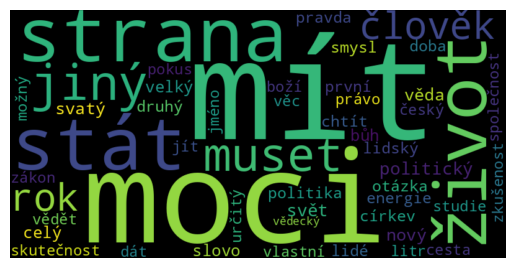

In [49]:
wc = WordCloud(width=800, height=400).generate_from_frequencies(dict(periods_freqs[periods_labels[0]][:50]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

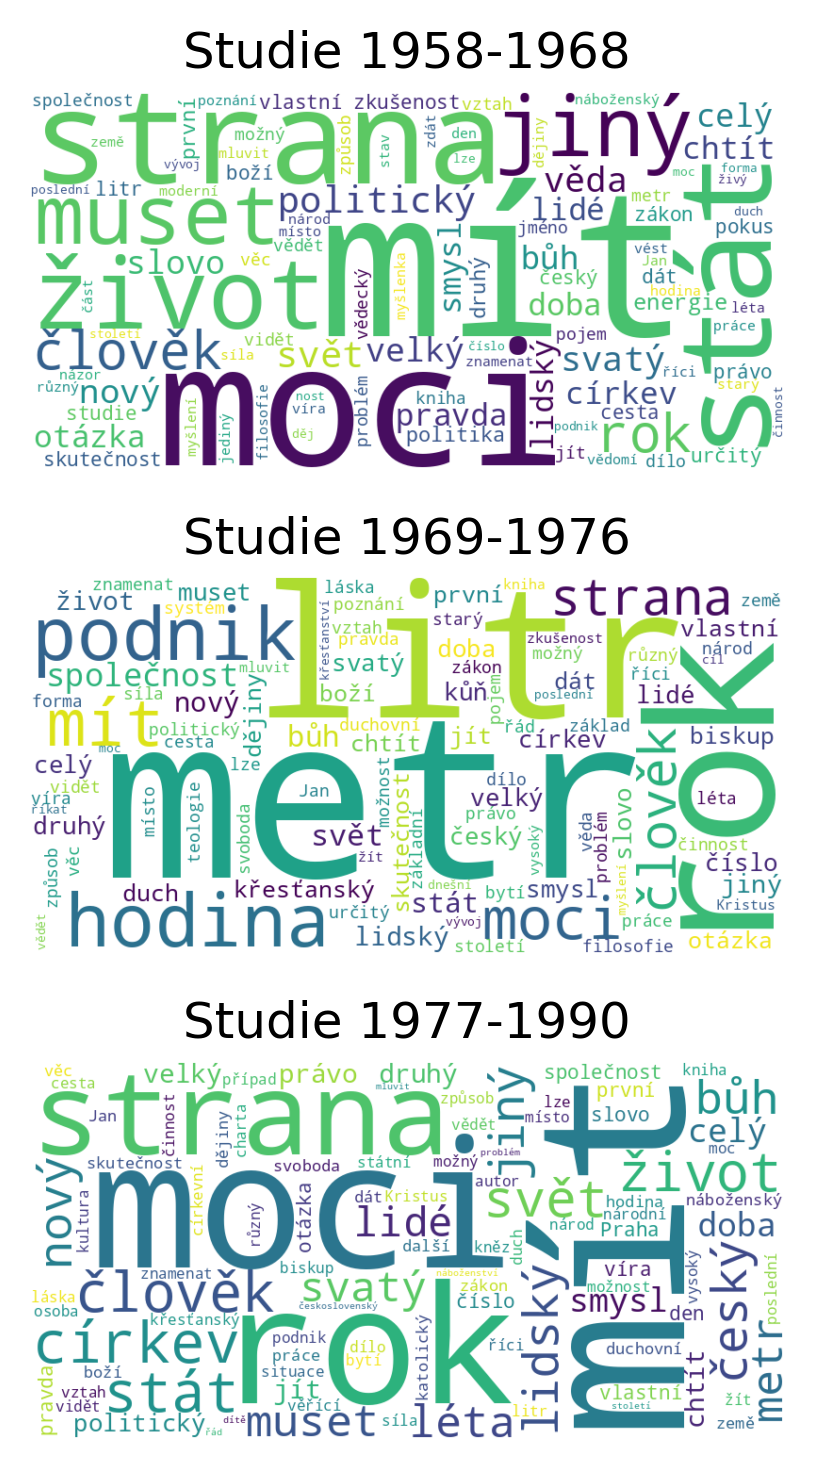

In [50]:
n = 100
fig, axs = plt.subplots(3,1, figsize=(4.5, 5) , dpi=300, tight_layout=True)
for item, ax in zip(periods_freqs.items(), axs.ravel()):    
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(dict(item[1][:n]))
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(item[0])
    ax.axis("off")

### Lematizované věty s vybranými slovy

Nyní si nadefinujeme funkci, pomocí které budeme moci vyextrahovat veškeré věty obsahující konkrétní slova.

In [ ]:
def extract_target_sents(lemmatized_sents, targets):
    try:
        return [sent for sent in lemmatized_sents if any(target in sent for target in targets)]
    except:
        return []

In [ ]:
my_targets = ["kultura"]
scriptum_df["target_sents"] = scriptum_df["lemmatized_sents"].apply(extract_target_sents, args=(my_targets,))

In [ ]:
scriptum_df["target_sents"].apply(lambda x: len(x) if x != None else 0).sum()

In [ ]:
scriptum_df["target_sents"]

Jaká slova se v těchto větách objevují nejčastěji?

In [ ]:
column_sents = scriptum_df["target_sents"].tolist()
target_sents_counts = nltk.FreqDist([t for sent in [t for sent in column_sents for t in sent] for t in sent]) #
target_sents_counts = target_sents_counts.most_common()
target_sents_counts[:20]

In [ ]:
wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(dict(target_sents_counts[:50]))
plt.imshow(wc) # , interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
column_sents = scriptum_df["target_sents"].tolist()
target_sents_counts = nltk.FreqDist([t for sent in [t for sent in column_sents for t in sent] for t in sent]) #
target_sents_counts = target_sents_counts.most_common()
target_sents_counts[:20]